# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru
- **Поддержка CUDA**: А.Е.Григорьева admin@linkennt.ru
- **Ревизия**: 9

- **Другие ревизии**:
  - С 1 по 7: [Яндекс Диск](https://disk.yandex.ru/d/aZozDpBlzh_z1A)
  - 8 и далее: [GitHub releases page](https://github.com/LISA-ITMO/CGT4NN/releases)
<!-- please do not append text into this block -->

## DONE

> Gradient dropout - не все игроки не всегда получают выигрыш

- [x] Больше скрытых слоёв! (теперь их 5)
    - [x] В скрытых слоях 100-200 нейронов
    - [x] Попробовать что-то кроме 3 слоёв

Для этого мы вводим класс `AugmentedReLUNetworkMultilayer`, который расширяет
интерфейс `AugmentedReLUNetwork` параметром `hidden_layers_count`.

- [x] Взять датасет с плохим перфомансом
    - [x] Какой же из них с плохим перфомансом? Разве не все?
      - Я думаю, что #4, его $R^2$ ниже -15
    - $R^2$ увеличился с -15 до -2 🎉
- [x] $\alpha \in \{ 1, 1.12, 2 \}$
- [x] Использовать sMAPE вместо $R^2$

## TODO

- [ ] Пересчитать эксперименты в SMAPe
- [ ] Если Y -> R это оптимизатор, то плохая композициональность

Best Response: шаг в сторону градиентного спуска

Как сделать композициональнее - функция ошибки это специфический вид слоя

Принимат выход сетки, отдаёт градиент лосс функции

В этом случае у нас весь механизм замыкается, а замкнутой и контролируемой и обучаемой обучение прои

- [ ] Проинтерпретировать как открытую игру

- [ ] Статья про коммуникацию между агентами есть у Ивана

- [ ] Переделываем через композиционную игру

- неархимедовы вероятности, p-адические числа

- [ ] Визуализация через [github:CyberCat-Institute/open-game-engine](https://github.com/CyberCat-Institute/open-game-engine)


======

- [ ] не право голоса, а обратная связь отключается

- [ ] F1 Smape

- [ ] сделать к табличкам описание наблюдаем то-то то-то

## BACKLOG

- [ ] Применять gradient dropout к половине сети и ко всей сети
- [ ] Варьировать шум от 0 до 1 (а не 2)
- [ ] Посмотреть, какой архитектурой решали MNIST character recognition на полносвязных сетях
    - [ ] Reference: https://github.com/ranimeshehata/Feed-Forward-Neural-Network-on-MNIST

- [ ] Использовать инициализацию *He* вместо *Xavier*
  - [ ] Сравнить
- [ ] Как оценить устойчивость случайной величины?
- [ ] На задаче классификации заменять класс $q$ на класс $r$ с заданной вероятностью, а вещественный шум использовать только для регрессии.


## Symmetric Mean Absolute Percentage Error (sMAPE)

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

Common in time series forecasting

$$ \mathrm{SMAPE} = {100 \over n}  \sum_{t=1}^{n} {{ |F_t - A_t| }\over{ (|A_t| + |F_t|)/2 }} $$

- $A_t$ - actual value
- $F_t$ - forecast value

Implementation of sMAPE is avaiable in the `torchmetrics` library:
https://torchmetrics.readthedocs.io/en/v1.0.0/regression/symmetric_mean_absolute_percentage_error.html

In [3]:
import torch
from torchmetrics import SymmetricMeanAbsolutePercentageError

target = torch.tensor([1, 10, 1e6])
preds = torch.tensor([0.9, 15, 1.2e6])

smape = SymmetricMeanAbsolutePercentageError()
smape(preds, target) # tensor(0.2290)

tensor(0.2290)

Compare to $R^2$:

In [4]:
from sklearn.metrics import r2_score

r2_score(preds, target) # 0.9583327812227765

0.9583327812227765

In [10]:
from cgtnnlib.LearningTask import is_regression_task
import cgtnnlib.datasets as ds

# list(filter(lambda x: is_regression_task(x.learning_task), ds.datasets))
[ds.datasets[8], ds.datasets[9]]

[Dataset #9 {
   name: "294_satellite_image"
   learning_task: LearningTask(name='regression', criterion=MSELoss(), y_dtype=torch.float32)
   classes_count: 1
   target: "target"
   _data: DatasetData(df=      attr1  attr2  attr3  attr4  attr5  attr6  attr7  attr8  attr9  attr10  \
 0      92.0  115.0  120.0   94.0   84.0  102.0  106.0   79.0   84.0   102.0   
 1      84.0  102.0  106.0   79.0   84.0  102.0  102.0   83.0   80.0   102.0   
 2      84.0  102.0  102.0   83.0   80.0  102.0  102.0   79.0   84.0    94.0   
 3      80.0  102.0  102.0   79.0   84.0   94.0  102.0   79.0   80.0    94.0   
 4      84.0   94.0  102.0   79.0   80.0   94.0   98.0   76.0   80.0   102.0   
 ...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
 6430   60.0   83.0   96.0   85.0   64.0   87.0  100.0   88.0   64.0    83.0   
 6431   64.0   79.0  100.0   85.0   56.0   71.0   96.0   85.0   56.0    68.0   
 6432   56.0   68.0   91.0   81.0   56.0   64.0   91.0   81.0   53.0    64.0 

## Setup

In [10]:
from typing import Callable
from cgtnnlib.Dataset import Dataset
from cgtnnlib.constants import LEARNING_RATE, RANDOM_STATE
import cgtnnlib.training as tr
import cgtnnlib.datasets as ds
from cgtnnlib.NoiseGenerator import NoiseGenerator, target_dispersion_scaled_noise, stable_noise, no_noise_generator

iterations = 10
"Число моделей в каждом эксперименте"

pp = [0.0, 0.5, 0.9]
"Набор гиперпараметров gradient dropout"

hidden_layers_count = 5
"Число скрытых слоёв"

inner_layer_size = 150
"Число нейронов в скрытых слоях"

datasets = [ds.datasets[2], ds.datasets[5], ds.datasets[8], ds.datasets[9]]
"Наборы данных, на которых проводить эксперимент"

#output_dir = 'rev9' #3 layers
#output_dir = 'rev9.2' #5 layers
output_dir = 'rev9.3' #5 layers, 
"Папка с результатами"

def dir_path(d: Dataset, p: float, n: NoiseGenerator):
    "Путь каталога эксперимента"
    return f'{output_dir}/dataset{d.number}_p{p}_noise{n.name}/'

def model_path(d: Dataset, p: float, n: NoiseGenerator, N: int):
    "Путь файла PyTorch модели (`.pth`)"
    return f'{output_dir}/dataset{d.number}_p{p}_noise{n.name}/{N}.pth'

def report_filename(d: Dataset, p: float, n: NoiseGenerator, N: int):
    "Имя файла отчёта (`.json`, см. `cgtnnlib/Report.py`)"
    return f'dataset{d.number}_p{p}_noise{n.name}/{N}.json'

def report_path(d: Dataset, p: float, n: NoiseGenerator, N: int):
    "Путь файла отчёта (`.json`, см. `cgtnnlib/Report.py`)"
    return f'{output_dir}/{report_filename(d, p, n, N)}'

def epochs_for_dataset(dataset: Dataset):
    return 10


ng_makers: list[Callable[[Dataset], NoiseGenerator]] = [
    lambda _: no_noise_generator,
    lambda d: target_dispersion_scaled_noise(
        dataset=d,
        factor=0.03,
        random_seed=RANDOM_STATE + 1,
    ),
    lambda d: stable_noise(
        dataset=d,
        factor=0.03,
        alpha=1,
        beta=0,
    ),
    lambda d: stable_noise(
        dataset=d,
        factor=0.03,
        alpha=1.12,
        beta=0,
    ),
    lambda d: stable_noise(
        dataset=d,
        factor=0.03,
        alpha=2.0,
        beta=1,
    ),
]
"Генераторы шумов для примешивания ко входам"

'setup complete'

'setup complete'

Я не понимаю, почему мы примешиваем шум именно ко входам.
Может, там и не так всё делается.

## Training

### Model B

- both take ~5m 06s to train 10 iterations
- both on both noises: about ~10m

<hr>

- `ds.datasets['StudentPerformanceFactors']` takes ~2m 30s to train 10 iterations
- `ds.datasets['wine_quality']` takes ~2m 36s to train 10 iterations

<hr>

- `ds.datasets['allhyper']` takes ~36m to train on all noise generators

### Model B*

3 hidden layers:
- ~15m 38s: Dataset #3, 10 epochs, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ 
- ~9m 30s: Dataset #3, 10 epochs, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ 

5 hidden layers:
- ~14m 10s: Dataset #3, 10 epochs, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ 

- ~93m 23s: Datasets {#3, #6, #9, #10}, 10 epochs, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ 
- ~147m 33s: Datasets {#3, #6, #9, #10}, 20 epochs, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ 


In [28]:
# ## Fast training

# import os

# from cgtnnlib.Report import Report
# from cgtnnlib.nn.AugmentedReLUNetworkMultilayer import AugmentedReLUNetworkMultilayer

# dataset = ds.datasets['1030_ERA']
# p = 0.5
# noise_generator = no_noise_generator
# epochs = 10

# for iteration in range(iterations):
#     os.makedirs(dir_path(dataset, p, noise_generator), exist_ok=True)
#     report = Report(
#         dir=output_dir,
#         filename=report_filename(d=dataset, p=p,
#                                     n=noise_generator, N=iteration)
#     )
#     tr.super_train_model(
#         make_model=lambda: AugmentedReLUNetworkMultilayer(
#             inputs_count=dataset.features_count,
#             outputs_count=dataset.classes_count,
#             p=p,
#             inner_layer_size=inner_layer_size,
#             hidden_layers_count=hidden_layers_count,
#         ),
#         model_path=model_path(d=dataset, p=p,
#                                 n=noise_generator, N=iteration),
#         dataset=dataset,
#         report=report,
#         epochs=epochs_for_dataset(dataset),
#         learning_rate=LEARNING_RATE,
#         dry_run=False,
#         iteration=iteration,
#         noise_generator=noise_generator,
#     )

# 'training complete'

In [31]:
## Training

import os

from cgtnnlib.Report import Report
from cgtnnlib.nn.AugmentedReLUNetworkMultilayer import AugmentedReLUNetworkMultilayer

for i, dataset in enumerate(datasets):
    for ng_maker in ng_makers:
        for p in pp:
            noise_generator = ng_maker(dataset)
            for iteration in range(iterations):
                os.makedirs(dir_path(dataset, p, noise_generator), exist_ok=True)
                report = Report(
                    dir=output_dir,
                    filename=report_filename(d=dataset, p=p,
                                             n=noise_generator, N=iteration)
                )
                tr.super_train_model(
                    make_model=lambda: AugmentedReLUNetworkMultilayer(
                        inputs_count=dataset.features_count,
                        outputs_count=dataset.classes_count,
                        p=p,
                        inner_layer_size=inner_layer_size,
                        hidden_layers_count=hidden_layers_count,
                    ),
                    model_path=model_path(d=dataset, p=p,
                                          n=noise_generator, N=iteration),
                    dataset=dataset,
                    report=report,
                    epochs=epochs_for_dataset(dataset),
                    learning_rate=LEARNING_RATE,
                    dry_run=False,
                    iteration=iteration,
                    noise_generator=noise_generator,
                )

'training complete'

N=9 #10 gStable10A2.0B1F0.03 p=0.9 E9/10 S67 Loss=0.0407@AugmentedReLUNetworkMultilayer
create_and_train_model(): saved model to rev9.3/dataset10_p0.9_noiseStable10A2.0B1F0.03/9.pth
Report saved to rev9.3/dataset10_p0.9_noiseStable10A2.0B1F0.03/9.json.


'training complete'

## Evaluation & Analysis

~2m 44s: Dataset #3, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ 

~15m 32s: Datasets {#3, #6, #9, #10}, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ }

In [12]:
# ## A single evaluation for quick evaluations

# dataset = ds.datasets['1030_ERA']
# noise_generator = no_noise_generator
# p = 0.5

# ax_drawer = make_ax_drawer(
#     dataset=dataset,
#     title=f'Dataset #{dataset.number}: {dataset.name}, {noise_generator.name}, p = {p}',
#     get_report_path=lambda N: report_path(dataset, p,
#                                           noise_generator, N),
#     get_model_path=lambda N: model_path(dataset, p,
#                                         noise_generator, N),
#     p=p,
#     metric='mse',
# )

# ax_drawer(plt)

<string>:137: SyntaxWarning: invalid escape sequence '\{'
<>:137: SyntaxWarning: invalid escape sequence '\{'
<string>:137: SyntaxWarning: invalid escape sequence '\{'
<>:137: SyntaxWarning: invalid escape sequence '\{'
/var/folders/m9/y193wddj505gjbgjyvhjmzjm0000gq/T/ipykernel_70223/1471405135.py:137: SyntaxWarning: invalid escape sequence '\{'
  fig.suptitle(f'Dataset #{dataset.number}: {dataset.name}\{MODEL_TYPE.__name__}', fontsize=16)


Report found at rev9.3/dataset3_p0.0_noiseNoNoise/0.json. Loading...
Report loaded.
... Skipping evaluation of dataset3_p0.0_noiseNoNoise/0.json
read_eval_from_iteration rev9.3/dataset3_p0.0_noiseNoNoise/0.json 0
Report found at rev9.3/dataset3_p0.0_noiseNoNoise/1.json. Loading...
Report loaded.
... Skipping evaluation of dataset3_p0.0_noiseNoNoise/1.json
read_eval_from_iteration rev9.3/dataset3_p0.0_noiseNoNoise/1.json 1
Report found at rev9.3/dataset3_p0.0_noiseNoNoise/2.json. Loading...
Report loaded.
... Skipping evaluation of dataset3_p0.0_noiseNoNoise/2.json
read_eval_from_iteration rev9.3/dataset3_p0.0_noiseNoNoise/2.json 2
Report found at rev9.3/dataset3_p0.0_noiseNoNoise/3.json. Loading...
Report loaded.
... Skipping evaluation of dataset3_p0.0_noiseNoNoise/3.json
read_eval_from_iteration rev9.3/dataset3_p0.0_noiseNoNoise/3.json 3
Report found at rev9.3/dataset3_p0.0_noiseNoNoise/4.json. Loading...
Report loaded.
... Skipping evaluation of dataset3_p0.0_noiseNoNoise/4.json
rea

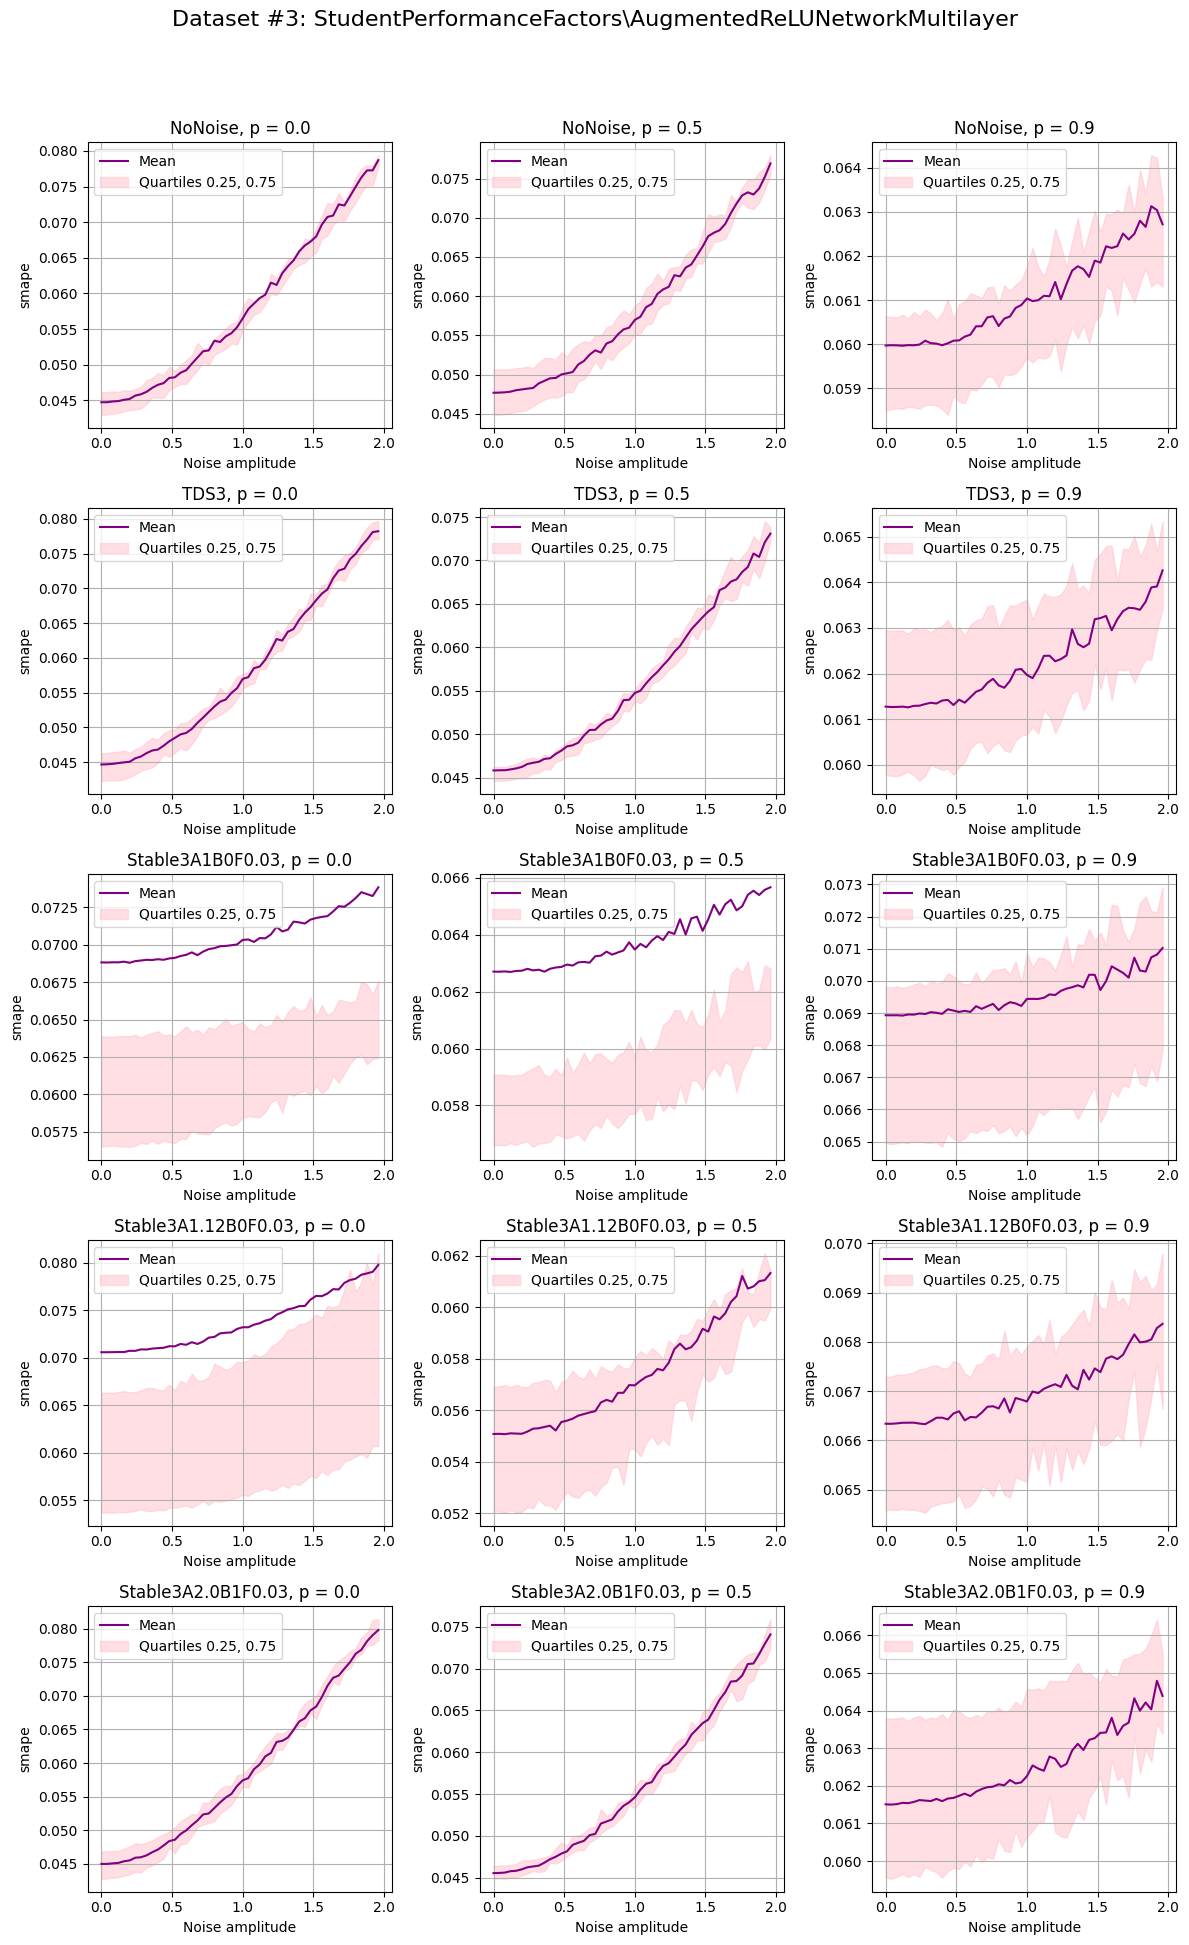

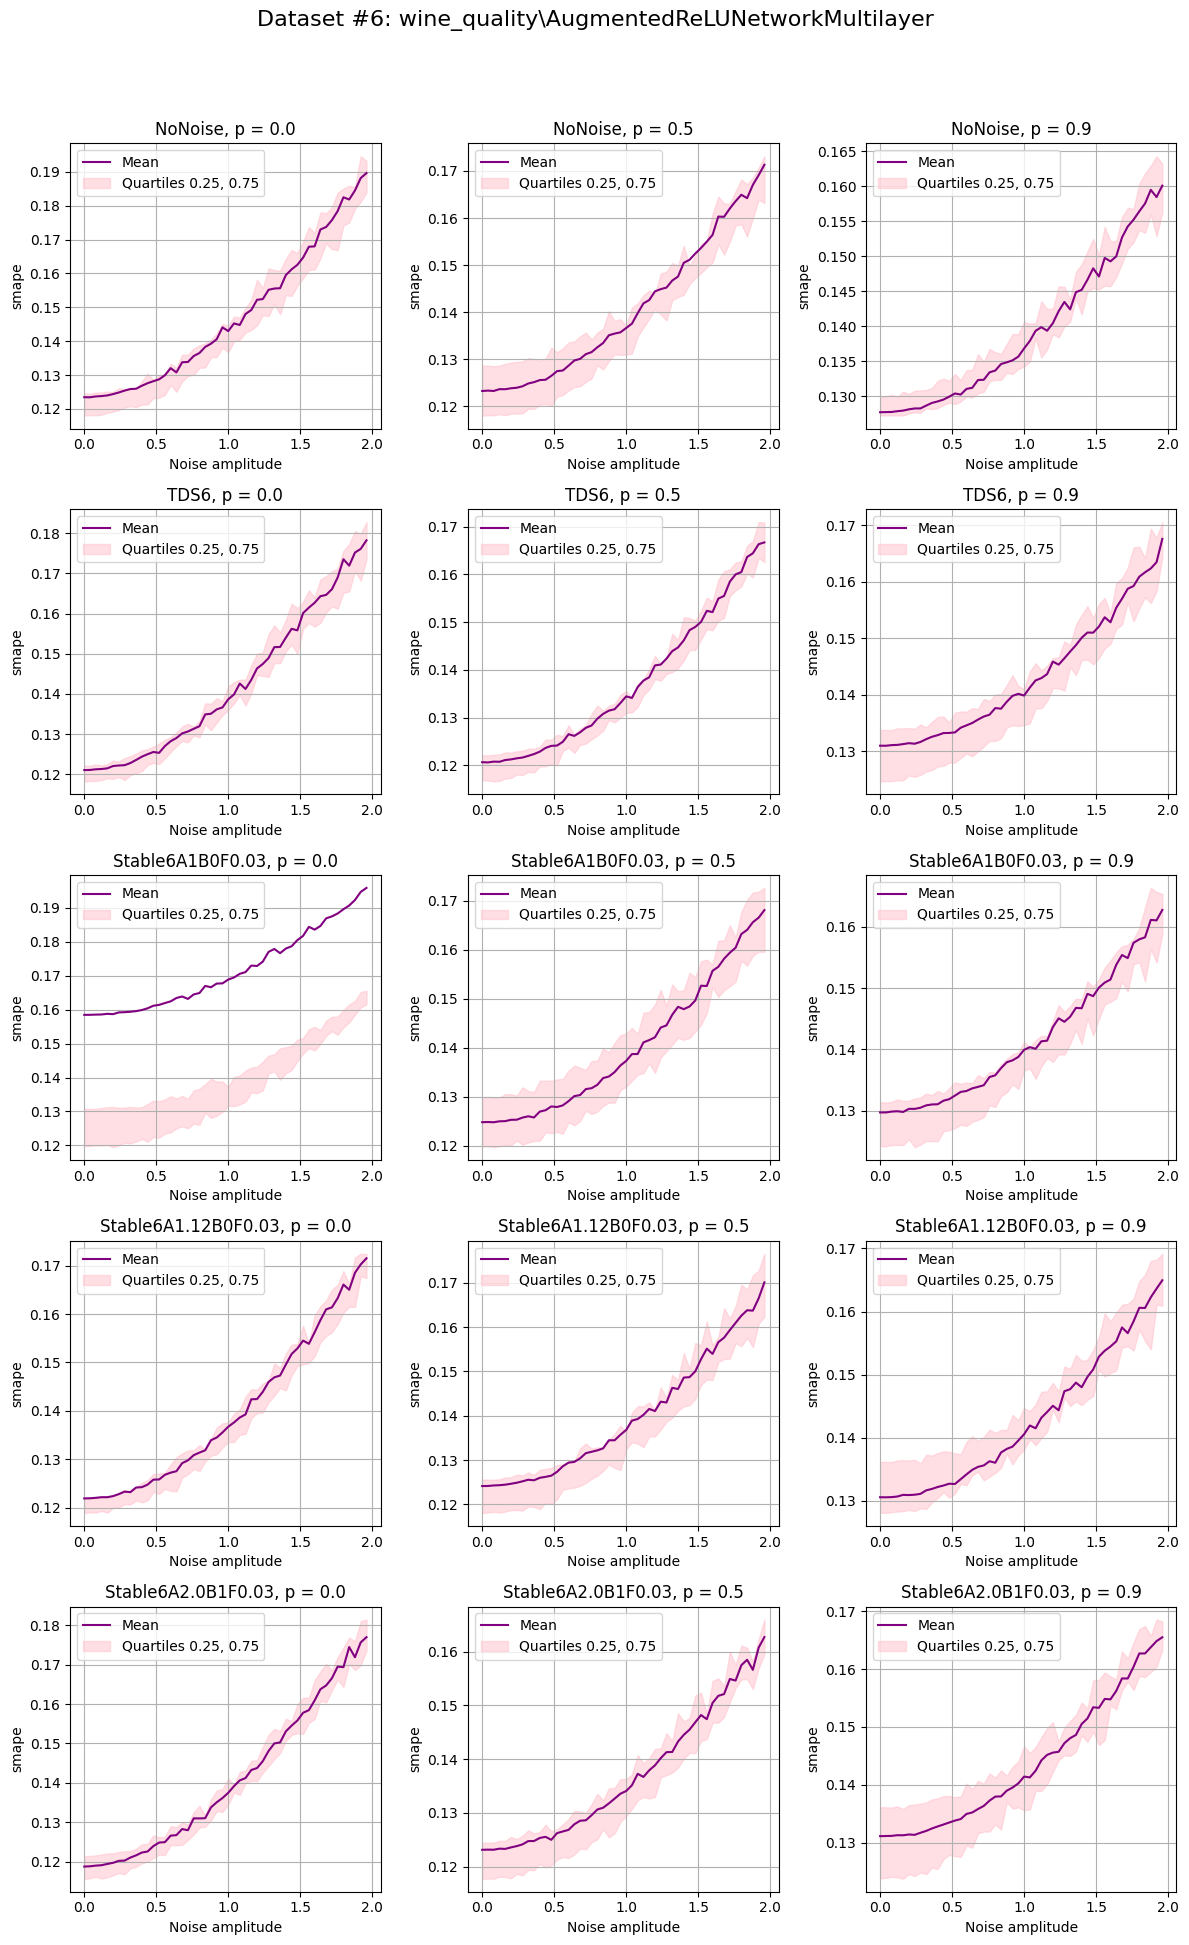

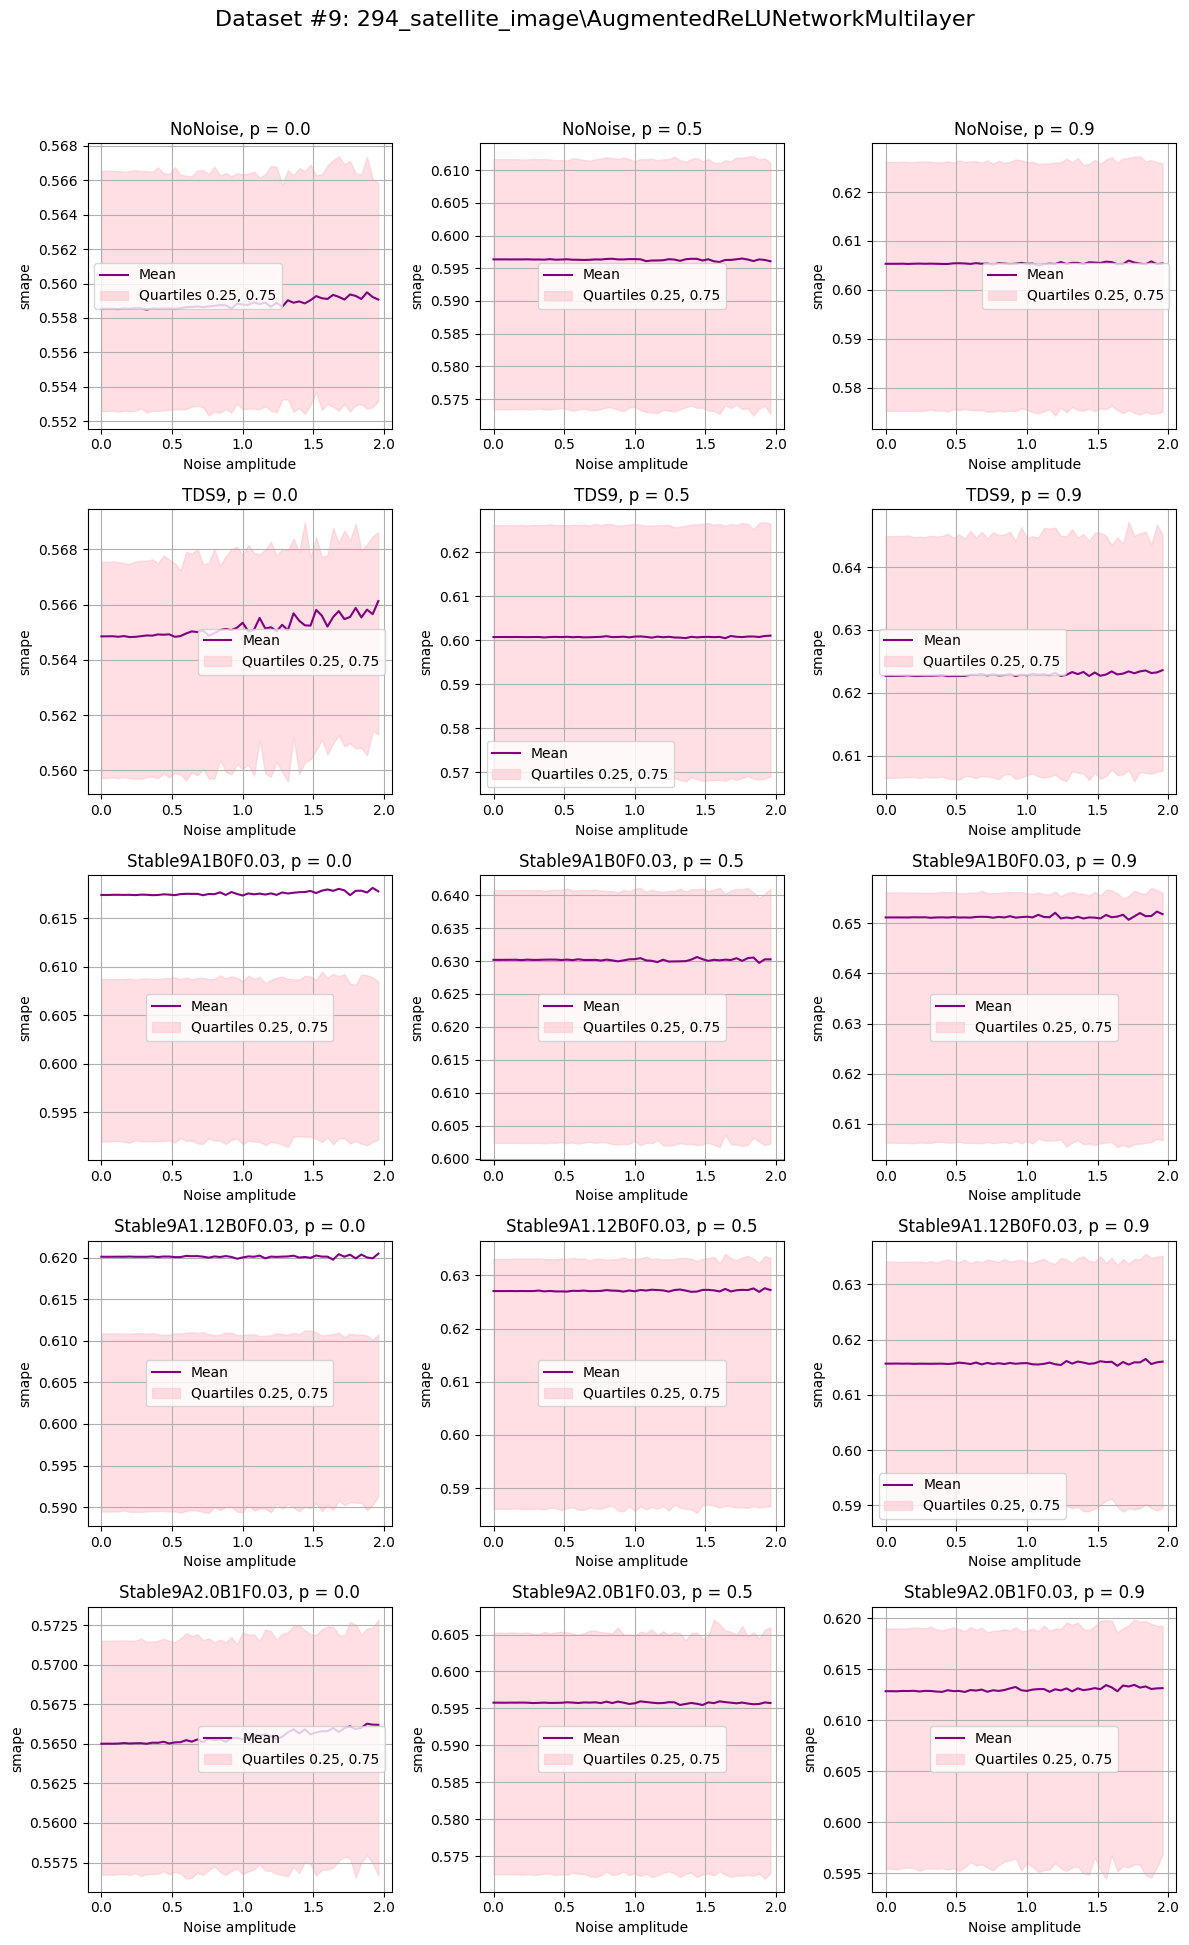

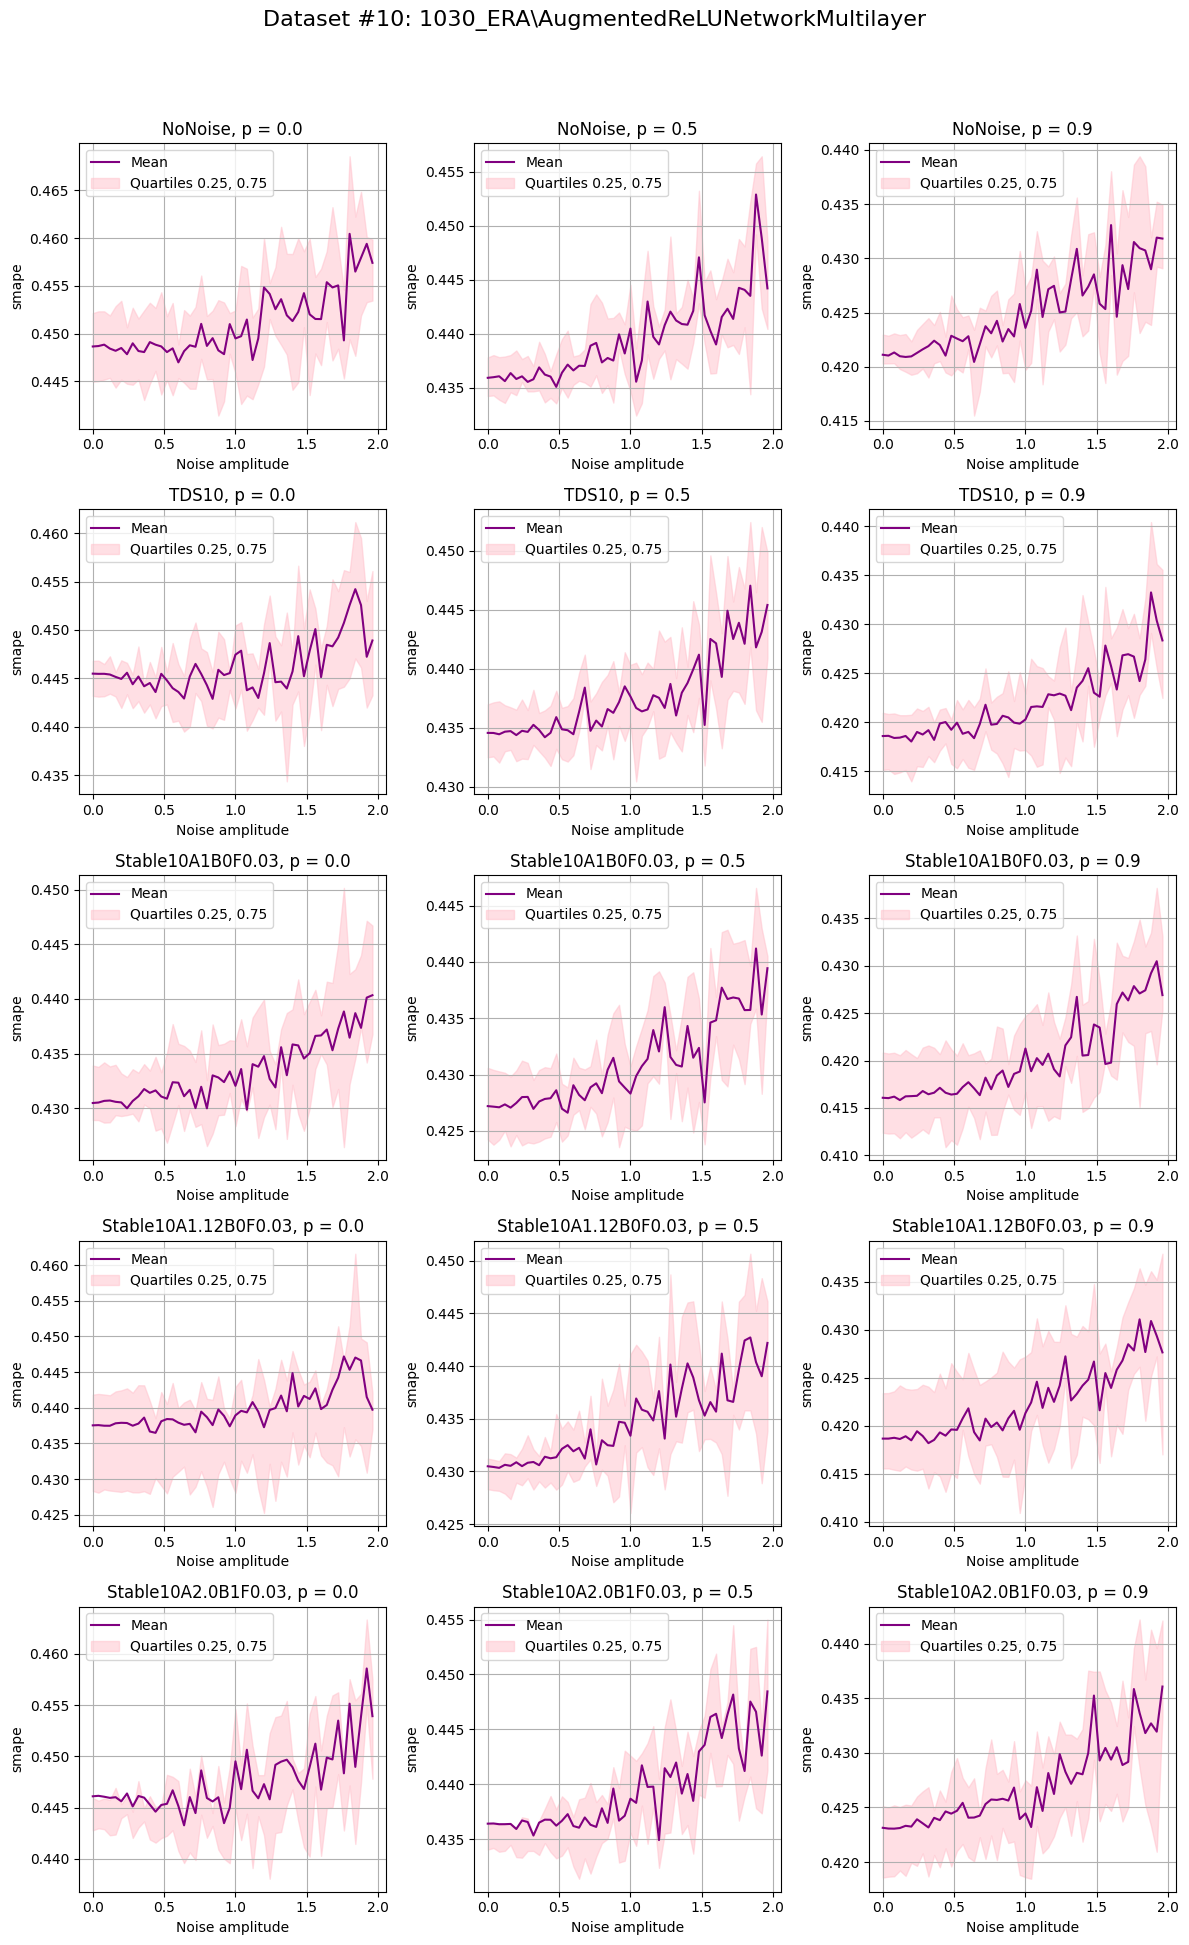

In [27]:
## Single Plot Analysis

import json

import pandas as pd

import torch

import matplotlib.pyplot as plt

from cgtnnlib.Report import Report
from cgtnnlib.LearningTask import is_classification_task
from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt
from cgtnnlib.constants import NOISE_FACTORS
from cgtnnlib.evaluate import eval_report_at_path, super_eval_model
from cgtnnlib.nn.AugmentedReLUNetworkMultilayer import AugmentedReLUNetworkMultilayer


MODEL_TYPE = AugmentedReLUNetworkMultilayer


def read_json(path: str) -> dict:
    with open(path) as file:
        return json.load(file)

def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame({
        0.25: df.quantile(0.25, axis=1),
        0.75: df.quantile(0.75, axis=1),
        'mean': df.mean(axis=1),
    })

    return summary_df

def make_ax_drawer(
    dataset: Dataset,
    title: str,
    get_report_path: Callable[[int], str],
    get_model_path: Callable[[int], str],
    p: float,
    metric: str,
):
    def read_eval_from_iteration(n) -> pd.DataFrame:
        path = get_report_path(n)
        report = Report.from_path(path)
        
        model = MODEL_TYPE(
            inputs_count=dataset.features_count,
            outputs_count=dataset.classes_count,
            p=p,
            inner_layer_size=inner_layer_size,
            hidden_layers_count=hidden_layers_count,
        )
        model.eval()
        model.load_state_dict(torch.load(get_model_path(n)))
        super_eval_model(
            dataset=dataset,
            model=model,
            report=report,
        )
        print('read_eval_from_iteration', path, n)
        return pd.DataFrame(read_json(path)['eval'])
    
    def read_loss_from_iteration(n) -> pd.DataFrame:
        path = get_report_path(n)
        json = read_json(path)
        return pd.DataFrame({ 'loss': json['loss'] })

    files = [
        read_eval_from_iteration(n)
        for n in range(iterations)
    ]
            
    print(f'Processing {get_report_path(0)}...')

    curve = summarize_series_list([file[metric] for file in files])

    def draw_ax(ax):
        plot_deviant_curves_on_ax_or_plt(
            ax_or_plt=ax,
            models=[{
                'curve': curve,
                'color': 'purple',
                'label': 'Mean',
                'quantiles_color': 'pink',
                'quantiles_label': 'Quartiles 0.25, 0.75', 
            }],
            X=NOISE_FACTORS,
            title=title,
            xlabel='Noise amplitude',
            ylabel=metric,
            quantiles_alpha=0.5,
        )
    
    return draw_ax

## A plot grid for multiple experiment evaluations

ax_drawers = [
    [[
        (lambda noise_generator: make_ax_drawer(
            dataset=dataset,
            title=f'{noise_generator.name}, p = {p}',
            get_report_path=lambda N: report_path(dataset, p,
                                                  noise_generator, N),
            get_model_path=lambda N: model_path(dataset, p,
                                                noise_generator, N),
            p=p,
            metric='smape',
        ))(noise_generator=ng_maker(dataset))
        for p in pp
    ] for ng_maker in ng_makers]
    for dataset in datasets
]

print(ax_drawers)
(nrows, ncols) = (
    len(ax_drawers[0]),
    len(ax_drawers[0][0]),
)

print(f'Size: {nrows}x{ncols}')

figsize = (12, 20)
"(width, height), inches"

for i, dataset in enumerate(datasets):

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    for j in range(nrows):
        for k in range(ncols):
            ax_drawers[i][j][k](axes[j, k])
    
    fig.suptitle(f'Dataset #{dataset.number}: {dataset.name}\{MODEL_TYPE.__name__}', fontsize=16)
    plt.tight_layout(rect=[0, 0.01, 1, 0.95]) # rect adjusts space for suptitle
    plt.show()

### Trying 5 layers

Smape goes down (p = 0):
- 0.1 -> 0.08
- 0.10 -> 0.085
- 0.10 -> 0.085
- 0.09 ~> 0.095 (goes up on Stble4A.12B0F0.03)
- 0.11 -> 0.085

In [14]:
import numpy as np
np.abs(np.array([
    0.1 - 0.08,
    0.1 - 0.085,
    0.10 - 0.085,
    0.09 - 0.095,
    0.11 - 0.085,
])).mean()

0.016

So we gain ~0.016 of sMAPE for adding 2 layers

In [15]:
x = 610 / 350 * 759
x

1322.8285714285714

## References

1. Chambers, J. M., Mallows, C. L., & Stuck, B. W. (1976). A method for simulating stable random variables. *Journal of the American Statistical Association*, *71*(354), 340-344.
2. M. Firouzi, A. Mohammadpour. A Survey on Simulating Stable Random Variables. URL: https://www.semanticscholar.org/reader/11a1e93642dc0a5c94e6906bcca5e4d25d4e9d46